In [1]:
from PIL import Image
import numpy as np
import os
from random import shuffle
from tqdm import tqdm
import matplotlib.pyplot as plt

TRAIN_DIR = './TRAIN'
TEST_DIR = './TEST'

IMG_SIZE = 120
LR = 1e-3

MODEL_NAME = 'NIKEvsADIDAS--{}-{}.model'.format(LR, '2conv-basic')

In [2]:
def label_img(img):
    # Les images sont formatées: ADIDAS_1, NIKE_3 ...
    word_label = img.split('_')[0]
    if word_label == 'NIKE': return [1,0] 
    elif word_label == 'ADIDAS': return [0,1] 

In [3]:
def create_train_data():
    train_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR, img)
        ############################################################    
        # Cette partie est différente du tutoriel de sentdex
        # Utilisation de PIL au lieu de cv2 pour le prétraitement d'image
        ############################################################
        
        img = Image.open(path) #Lecture de l'image avec PIL Library
        img = img.convert('L') #Grayscale conversion avec PIL library
        img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS) #Redimensionne les images avec PIL Library
        
        ############################################################
        
        train_data.append([np.array(img), np.array(label)])
    shuffle(train_data)
    np.save('train_data.npy', train_data) #.npy extension = numpy file
    return train_data


In [4]:
def process_test_data():
    test_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR, img)
        if "DS_Store" not in path:
            img_num = img.split('_')[1] #formattage image: 'NIKE_2', 'ADIDAS_56'..
        
            #PIL LIBRARY instead of cv2
            img = Image.open(path)
            img = img.convert('L')
            img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
        
            test_data.append([np.array(img), img_num])
    shuffle(test_data)
    np.save('test_data.npy', test_data)
    return test_data
        

  0%|                                                   | 0/100 [00:00<?, ?it/s]/var/folders/4b/g83qtk4x08nbc9j48pc6nkbc0000gn/T/ipykernel_17147/924497154.py:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS) #Redimensionne les images avec PIL Library
100%|████████████████████████████████████████| 100/100 [00:00<00:00, 212.64it/s]
/Users/julienparrot/Library/Python/3.8/lib/python/site-packages/numpy/lib/npyio.py:501: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


[1 0]


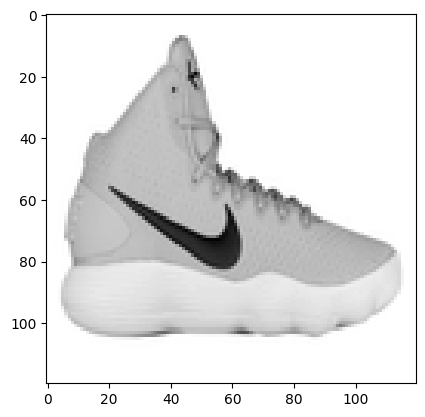

In [5]:
train_data = create_train_data()
plt.imshow(train_data[43][0], cmap = 'gist_gray')
print(train_data[43][1])


In [6]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
from tensorflow.python.framework import ops

ops.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name = 'input')
convnet = conv_2d(convnet, 32, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 32, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 32, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)
convnet = fully_connected(convnet, 1024, activation = 'relu')
convnet = dropout(convnet, 0.8)
convnet = fully_connected(convnet, 2, activation = 'softmax')
convnet = regression(convnet, optimizer = 'adam', learning_rate = LR, loss = 'categorical_crossentropy', name = 'targets')
model = tflearn.DNN(convnet, tensorboard_verbose=3)

2023-01-08 14:40:17.240651: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term
Scipy not supported!
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2023-01-08 14:40:23.297274: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 14:40:24.013263: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled


In [7]:
# FRACTIONNEMENT DES DONNÉES
# Le fractionnement des données est généralement effectué à 80 % en train et à 20 % en test
# des 80 % de nos données dans la rame
# on garde un  pourcentage comme ensemble de validation
# Ceci est utilisé pour faire le réglage des paramètres avant d'évaluer
# sur notre ensemble de test

train = train_data[-90:] #Train Set
test = train_data[:-90] #Validation Set

In [8]:
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_y = [i[1] for i in test]

In [9]:
model.fit({'input': X}, {'targets': Y}, n_epoch=100, validation_set=({'input': test_x}, {'targets': test_y}), snapshot_step=50, show_metric=True, run_id='NIKE_ADIDAS')

Training Step: 199  | total loss: 0.58639 | time: 1.380s
| Adam | epoch: 100 | loss: 0.58639 - acc: 0.8655 -- iter: 64/90
Training Step: 200  | total loss: 0.53711 | time: 2.970s
| Adam | epoch: 100 | loss: 0.53711 - acc: 0.8790 | val_loss: 0.10188 - val_acc: 1.0000 -- iter: 90/90
--


  0%|                                                    | 0/40 [00:00<?, ?it/s]/var/folders/4b/g83qtk4x08nbc9j48pc6nkbc0000gn/T/ipykernel_17147/320419732.py:11: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
100%|██████████████████████████████████████████| 40/40 [00:00<00:00, 210.14it/s]
/Users/julienparrot/Library/Python/3.8/lib/python/site-packages/numpy/lib/npyio.py:501: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


[0.34823012 0.6517699 ]
[0.5999101  0.40008992]
[0.2647211 0.7352789]
[0.18652967 0.81347036]
[0.9217946  0.07820547]
[0.7921799  0.20782019]
[0.7824089  0.21759105]
[0.9221029  0.07789713]
[0.90306723 0.09693279]
[0.81539255 0.18460739]


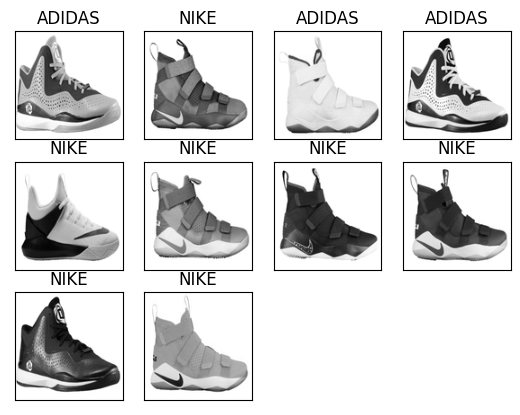

In [10]:
test_data = process_test_data()
fig = plt.figure()

for num, data in enumerate(test_data[:10]):
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    model_out = model.predict([data])[0]
    print(model_out)
    if np.argmax(model_out) == 1:
        str_label = 'ADIDAS'
    else:
        str_label = 'NIKE'
    
    y.imshow(orig, cmap = 'gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()